In [1]:
from az_common_funcs import *

2023-01-21 15:11:39,749 :: [INFO] :: Logger initialized WITHOUT file handler


In [2]:
df = pd.read_csv('naukri_data_science_jobs_india.csv')

In [3]:
"""Lets Check if the job experience column is not following the right pattern that is <min>-<max>"""
# To check
df[~df['Job Experience'].str.contains('-')].shape

(6, 5)

In [4]:
"""Since only 6 rows have wrong Job Experience Lets remove them from the Dataset"""
df = df[df['Job Experience'].str.contains('-')]

In [5]:
df['Job Experience'] = df['Job Experience'].str.replace(" ","") # remove empty spaces

In [6]:
"""Lets do a deeper check. This time with regex"""
import regex as re
je_pattern = re.compile("^[0-9]{1,2}-[0-9]{1,2}$")

In [7]:
je_str_pat_check = lambda string : True if re.search(je_pattern, string) else False

In [8]:
"""Lets see if the specified pattern is there in the remaining columns"""
df[~df['Job Experience'].apply(je_str_pat_check)].shape

(6, 5)

In [9]:
"""Again since it is only 6 rows and the values look erroneous too, we will remove the rows"""

'Again since it is only 6 rows and the values look erroneous too, we will remove the rows'

In [10]:
df = df[df['Job Experience'].apply(je_str_pat_check)]

In [11]:
""" Now Lets Split the job experience into two parts, min years and max years"""
df[['MIN_YRS_OF_EXP', 'MAX_YRS_OF_EXP']] = df['Job Experience'].str.split('-', expand = True)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11988 entries, 0 to 11999
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Job_Role            11988 non-null  object
 1   Company             11988 non-null  object
 2   Location            11988 non-null  object
 3   Job Experience      11988 non-null  object
 4   Skills/Description  11988 non-null  object
 5   MIN_YRS_OF_EXP      11988 non-null  object
 6   MAX_YRS_OF_EXP      11988 non-null  object
dtypes: object(7)
memory usage: 749.2+ KB


In [13]:
df.MIN_YRS_OF_EXP = df.MIN_YRS_OF_EXP.astype(int)
df.MAX_YRS_OF_EXP = df.MAX_YRS_OF_EXP.astype(int)

In [14]:
""" Lets check if by any chance the min yrs of exp column value > max yrs of exp column value"""
df[df.MIN_YRS_OF_EXP > df.MAX_YRS_OF_EXP].shape

(0, 7)

In [15]:
""" Lets move on to the Location Column """
df.Location.value_counts()[:5]

Bangalore/Bengaluru       3306
Pune                      1193
Hyderabad/Secunderabad     960
Mumbai                     809
Gurgaon/Gurugram           698
Name: Location, dtype: int64

In [16]:
""" 
Few Observations for data cleaning 

1. When there is a duality in name of a particular locaation like Bangalore/Bengaluru, it is written with a / in between 
2. When there are multiple locations, they are separated by COMMA
3. In some instances we need to remove info given in parenthesis to get the name of city

"""

' \nFew Observations for data cleaning \n\n1. When there is a duality in name of a particular locaation like Bangalore/Bengaluru, it is written with a / in between \n2. When there are multiple locations, they are separated by COMMA\n3. In some instances we need to remove info given in parenthesis to get the name of city\n\n'

In [17]:
""" So Lets handle all the cases and arrive at a comma separated list that only contains cities"""
""" For a sample we will take an instance that covers all the cases """
sample_location = "Chennai, Bangalore/Bengaluru, Mumbai (All Areas)"
list_locations = sample_location.split(',')
list_locations = [loc.split('/')[0] for loc in list_locations]
parenth_pattern = re.compile("\([\w\s\S]*\)")
list_locations = [re.sub(parenth_pattern,"",loc) if re.search(parenth_pattern,loc) else loc for loc in list_locations]
list_locations = [loc.strip() for loc in list_locations] 

In [18]:
parenth_pattern = re.compile("\([\w\s\S]*\)")
def locations_cleaner(loc_element):
    list_locations = loc_element.split(',')
    list_locations = [loc.split('/')[0] for loc in list_locations]
    list_locations = [re.sub(parenth_pattern,"",loc) if re.search(parenth_pattern,loc) else loc for loc in list_locations]
    list_locations = [loc.strip() for loc in list_locations] 
    return list_locations

In [19]:
df['proper_location'] = df['Location'].apply(locations_cleaner)

In [20]:
# Shape before explode
df.shape

(11988, 8)

In [21]:
df = df.explode('proper_location',ignore_index = True)

In [22]:
locations_dist = df.proper_location.value_counts().cumsum()/df.proper_location.value_counts().sum() * 100
locations_dist[:5]

Bangalore    28.503736
Pune         40.993864
Hyderabad    52.767147
Mumbai       61.648746
Chennai      69.534050
Name: proper_location, dtype: float64

In [23]:
""" Now we can see above that there are some problems in the location 
1. Some locations are repeated like Mumbai, Navi Mumbai
2. Some locations are repeated but with different case
3. Some locations are not city but country, like USA, India

Solution:
1. Lets remove all locations that represent less than 3% of the total data
2. Then in the remaining locations we can think of applying some cleaning techniques
"""
thresh = 97
print(f"Total Cities : {df.proper_location.nunique()}")
print(f"Cities representing more than {thresh}% of the data : {locations_dist[locations_dist<=thresh].shape[0]}")
print(f"Cities representing less than {thresh}% of the data : {locations_dist[locations_dist>thresh].shape[0]}")


Total Cities : 203
Cities representing more than 97% of the data : 27
Cities representing less than 97% of the data : 176


In [24]:
cities_to_keep = locations_dist[locations_dist<=thresh].index

In [25]:
df = df[df.proper_location.isin(cities_to_keep)]

In [26]:
df.proper_location.value_counts()

Bangalore          4692
Pune               2056
Hyderabad          1938
Mumbai             1462
Chennai            1298
Gurgaon            1286
Delhi               595
Noida               581
Bengaluru           407
Kolkata             286
Ahmedabad           220
Remote              190
New Delhi           187
Kochi               119
Indore               84
Jaipur               82
Trivandrum           69
Chandigarh           63
Mohali               62
Navi Mumbai          62
Coimbatore           56
Nagpur               34
Vadodara             31
Thane                28
Lucknow              26
Mumbai Suburban      25
United States        23
Name: proper_location, dtype: int64

In [27]:
""" We need to replace the following :
1. Delhi : New Delhi
2. Mumbai : Navi Mumbai, Thane, Mumbai Suburban

And Remove United States because we are only interested in Indian Jobs
"""
df.proper_location.replace(['New Delhi'], 'Delhi', inplace = True)
df.proper_location.replace(['Navi Mumbai', 'Thane', 'Mumbai Suburban'], 'Mumbai', inplace = True)

df = df[df.proper_location != 'United States']

In [28]:
# Job Roles with 0 Yrs of Experience
for x in range(0,6):
    print(f"Job Roles with upto {x} years of Exp and Percentage")
    print(df[df.MIN_YRS_OF_EXP <= x].shape[0], end = ' ')
    print(f"{df[df.MIN_YRS_OF_EXP <= x].shape[0]/ df.shape[0] * 100 : .2f} %")
    print(f"Unique Companies Hiring : {df[df.MIN_YRS_OF_EXP <= x].Company.nunique()} / {df.Company.nunique()}")
    print('\n')

Job Roles with upto 0 years of Exp and Percentage
510  3.20 %
Unique Companies Hiring : 251 / 3477


Job Roles with upto 1 years of Exp and Percentage
1796  11.27 %
Unique Companies Hiring : 887 / 3477


Job Roles with upto 2 years of Exp and Percentage
4512  28.31 %
Unique Companies Hiring : 1728 / 3477


Job Roles with upto 3 years of Exp and Percentage
7503  47.07 %
Unique Companies Hiring : 2407 / 3477


Job Roles with upto 4 years of Exp and Percentage
9998  62.73 %
Unique Companies Hiring : 2786 / 3477


Job Roles with upto 5 years of Exp and Percentage
12490  78.36 %
Unique Companies Hiring : 3148 / 3477




In [29]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

In [30]:
count = CountVectorizer()
word_count=count.fit_transform(df['Job_Role'])

tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(word_count)

df_idf = pd.DataFrame(tfidf_transformer.idf_, index=count.get_feature_names(),columns=["idf_weights"])
#inverse document frequency
df_idf.sort_values(by=['idf_weights'])

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,idf_weights
data,1.462354
engineer,2.013563
analyst,2.258331
senior,2.806039
scientist,3.088770
...,...
ilm,9.983440
iiot,9.983440
iics,9.983440
imps,9.983440


In [31]:
is_analyst = df['Job_Role'].str.lower().str.contains('analyst')
is_engineer = df['Job_Role'].str.lower().str.contains('engineer')
is_scientist = df['Job_Role'].str.lower().str.contains('scientist')
is_data = df['Job_Role'].str.lower().str.contains('data ',regex = True)

print(f"Contains data :: {is_data.sum()}")
print(f"\nContains analyst :: {is_analyst.sum()}")
print(f"Contains engineer :: {is_engineer.sum()}")
print(f"Contains scientist :: {is_scientist.sum()}")
print(f"\nContains data and analyst : {(is_data & is_analyst).sum()}")
print(f"Contains data and engineer : {(is_data & is_engineer).sum()}")
print(f"Contains data and scientist : {(is_data & is_scientist).sum()}")

Contains data :: 9921

Contains analyst :: 4559
Contains engineer :: 6367
Contains scientist :: 2000

Contains data and analyst : 1673
Contains data and engineer : 5313
Contains data and scientist : 1916


In [32]:
df['broad_job'] = pd.NA
df.loc[(is_data & is_analyst),'broad_job'] = 'Data Analyst'
df.loc[(is_data & is_engineer),'broad_job'] = 'Data Engineer'
df.loc[(is_data & is_scientist),'broad_job'] = 'Data Scientist'

In [33]:
df.broad_job.value_counts(dropna = False)

<NA>              7176
Data Engineer     5262
Data Scientist    1916
Data Analyst      1585
Name: broad_job, dtype: int64

In [34]:
df_data_strictly = df[df.broad_job.notnull()]
for x in range(0,6):
    print(f"Job Roles with upto {x} years of Exp and Percentage")
    print(df_data_strictly[df_data_strictly.MIN_YRS_OF_EXP <= x].shape[0], end = ' ')
    print(f"{df_data_strictly[df_data_strictly.MIN_YRS_OF_EXP <= x].shape[0]/ df_data_strictly.shape[0] * 100 : .2f} %")
    print(f"Unique Companies Hiring : {df_data_strictly[df_data_strictly.MIN_YRS_OF_EXP <= x].Company.nunique()} / {df_data_strictly.Company.nunique()}")
    print('\n')

Job Roles with upto 0 years of Exp and Percentage
202  2.31 %
Unique Companies Hiring : 119 / 2273


Job Roles with upto 1 years of Exp and Percentage
839  9.57 %
Unique Companies Hiring : 463 / 2273


Job Roles with upto 2 years of Exp and Percentage
2352  26.84 %
Unique Companies Hiring : 995 / 2273


Job Roles with upto 3 years of Exp and Percentage
4004  45.69 %
Unique Companies Hiring : 1505 / 2273


Job Roles with upto 4 years of Exp and Percentage
5494  62.70 %
Unique Companies Hiring : 1782 / 2273


Job Roles with upto 5 years of Exp and Percentage
6971  79.55 %
Unique Companies Hiring : 2049 / 2273




In [35]:
df[df.broad_job.notnull()].proper_location.value_counts()

Bangalore     2499
Pune          1229
Hyderabad     1104
Mumbai         817
Chennai        757
Gurgaon        678
Delhi          427
Noida          282
Bengaluru      231
Kolkata        164
Remote         125
Ahmedabad      111
Kochi           67
Indore          43
Jaipur          40
Trivandrum      36
Chandigarh      33
Mohali          32
Coimbatore      32
Nagpur          22
Lucknow         18
Vadodara        16
Name: proper_location, dtype: int64

In [36]:
df_ds = df[df.broad_job == 'Data Scientist']
df_de = df[df.broad_job == 'Data Engineer']
df_da = df[df.broad_job == 'Data Analyst']

In [41]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

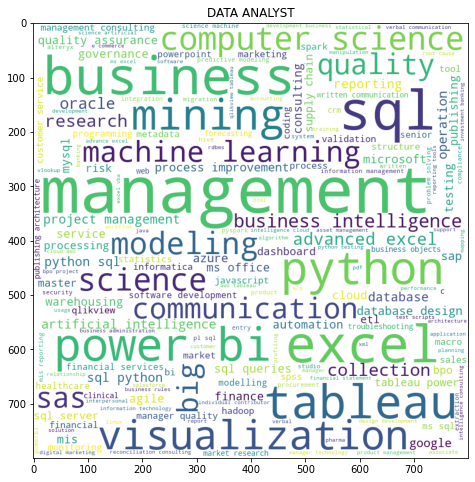

In [42]:
df_word_cloud = df_da

comment_words = ''
stopwords = set(STOPWORDS)
custom_stopwords = {'data', 'analyst', 'analytical','analysis', 'analytics', 'skill', 'skills'}
stopwords.update(custom_stopwords)
 
# iterate through the csv file
for val in df_word_cloud['Skills/Description']:
     
    # typecaste each val to string
    val = str(val)
 
    # split the value
    tokens = val.split()
     
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 800,
            background_color ='white',
            stopwords = stopwords,
            min_font_size = 10).generate(comment_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.title('DATA ANALYST')
plt.imshow(wordcloud)

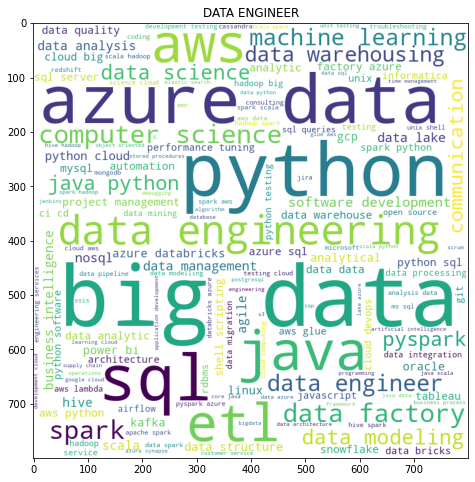

In [39]:
df_word_cloud = df_de

comment_words = ''
stopwords = set(STOPWORDS)
custom_stopwords = {'skill', 'skills'}
stopwords.update(custom_stopwords)

# iterate through the csv file
for val in df_word_cloud['Skills/Description']:
     
    # typecaste each val to string
    val = str(val)
 
    # split the value
    tokens = val.split()
     
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 800,
            background_color ='white',
            stopwords = stopwords,
            min_font_size = 10).generate(comment_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.title('DATA ENGINEER')
plt.imshow(wordcloud)

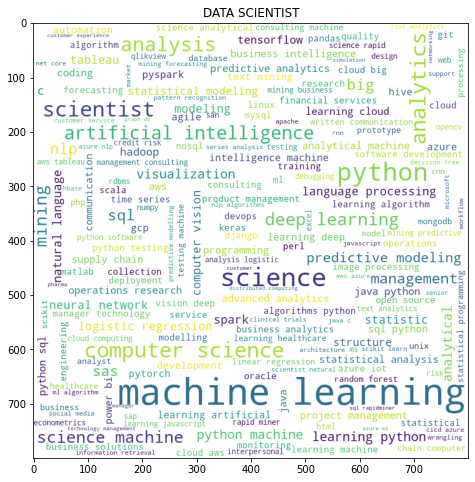

In [40]:
df_word_cloud = df_ds

comment_words = ''
stopwords = set(STOPWORDS)
custom_stopwords = {'skills', 'data'}
stopwords.update(custom_stopwords)

# iterate through the csv file
for val in df_word_cloud['Skills/Description']:
     
    # typecaste each val to string
    val = str(val)
 
    # split the value
    tokens = val.split()
     
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 800,
            background_color ='white',
            stopwords = stopwords,
            min_font_size = 10).generate(comment_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.title("DATA SCIENTIST")
plt.imshow(wordcloud)